# Leidos DeepRacer Analysis

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs.

Once you've trained a model on the AWS platform, you can download the log files and use this notebook to get a better understanding of what your model is doing and how you might be able to improve it.
**You do not need to know how to code in Python to run this notebook**

This analysis notebook includes tools to:
- find best iteration of your model
- visualize reward distribution on the track
- visualize reward heatmap per episode or iteration
- identify hotspots on the track for your model
- understand probability distributions on simulated images
- plot lap speed heatmap

You are welcome to write your own code and add your own analysis if it helps you.

We have created a python module utils.py that goes along with this notebook. The purpose of the module is to house useful helper functions. Go poke around the module now or as they are used later in the notebook.

This notebook is meant to **help** you, not **overwhelm** you.  All of this can be useful, but by no means is it necessary to evaluate each indivudal run.  Walk through it at your own pace and decide what you want to use to help you have the most fun :)


## Download your Deep Racer Logs

Once you've trained a model, you can download your logs and use this notebook to analyze your model's performance.

On the DeepRacer AWS service page head over to "Your Models" underneath the "Reinforcement Learning" left-hand
tab. From there you will see the options highlighted in yellow below for
downloading your model and your logs (training or evaluation).

After you download your logs, you can either place them inside the `/logs` folder
for convenience or you may store them elsewhere on your computer. You will need
to provide their storage paths later.

Here is the format my model and training logs were downloaded in: <br />
jackson-test-model-model.tar.gz <br />
jackson-test-model-training_job_cxQFkAigQr2RkIm7FtIwNw_logs.tar-2.gz

This model and log archive are included as an example in this repo, check
logs/04-26-2024_15-28-08

Spend some time poking through the unpacked archive files, when you download
your logs and model, they will appear in a similar format.


# Notebook Setup

Before you begin, make sure that this notebook is using the deepracer-analysis conda environment.
If you haven't set up the conda environment, go back to the README and follow the directions there.

### Intel Optimizers
Often, we download a package or library, use it, and think no more of it. However, in the world of AI you will receive
significant benefit from considering how your code is being run. As a brief introduction, we would like to show you a
few libraries that have been optimized by Intel. 

In these notebooks and the provided conda environment, we use [intel optimized libraries](https://www.intel.com/content/www/us/en/developer/topic-technology/artificial-intelligence/overview.html) for pandas, sklearn, tensorflow, 
and numpy via Intel's math kernel library (mkl).  If you are working on a machine with intel cores, these libraries will
increase the speed and efficiency at which your code runs.  If you don't have Intel cores, the libraries will operate as
usual.

We strongly recommend that you browse through the Intel optimized libraries and see what you can adopt in your workflow
for Leidos.

We have personally received great speedup by utilizing these libraries.
As you continue your AI journey please remember to stop and check where your libraries come from and ask yourself if you
could construct your workflow in a superior way. Here are a few tips and tricks you can ask yourself in the future:

- Can I replace this loop with vectorization?
- Can I split up my computation across multiple CPU's or CPU cores?
- Can I split up my computation across a GPU or multiple GPU's?
- Is the overhead of parallelization worth it?
- Where does my library come from? Is it optimized for my system and is it using the fastest underlying construction? 

In [75]:
'''
This cell imports the libraries used in this notebook.  If you don't run this cell first, most of your code won't run.
'''

# Intra-Project Imports
import utils

# Apply sklearn intel acceleration patch.
import platform
if 'Intel' in platform.processor():
    if utils.is_package_installed('scikit-learn-intelex'):
        from sklearnex import patch_sklearn
        patch_sklearn()

# Standard Library Imports
from datetime import datetime
import glob
import json
import math
import pytz

# Third-Party Imports
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler

# These libraries are also intel optimized, however, you don't have to have an Intel processor to utilize the optimized
# versions.
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior
# tf.compat.v1.Session

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<function tensorflow.python.compat.v2_compat.disable_v2_behavior()>

In [91]:
'''
This cell produces a timestamp which we suggest using to name your experiments.
'''

# To view all timezones and find yours uncomment and run:
# print(pytz.all_timezones)

# It's best to keep your downloads and analysis notebooks organized, one way to
# do this is through the use of timestamps. You don't have to use this scheme,
# but you should come up with something!

# You can use the following timestamp as a means to organize your log folder
# names or git branch names. Just run this each time you download some new files
# and want to organize them!
# Example: logs/04-26-2024_15-28-08/...model.tar.gz
# pytz
# tz = pytz.timezone('America/los_angeles')
# tz.localize(datetime.now()).strftime('%m-%d-%Y_%H-%M-%S')

'\nThis cell produces a timestamp which we suggest using to name your experiments.\n'

# Update the path variables to your logs

In [76]:
'''
!!! PASTE YOUR FILE PATHS HERE!!!
To make accessing your logs easier, we're going to store the paths as variables.
Make sure to update this whenever you are doing analysis on a new model.
'''
# Paste the path to the folder where you will put all of your logs here within the quotations
LOG_PATH = Path('C:\AWS\deepracer-contestant\logs')

# Paste the name of the specific run folder you want to analyze here.  By default, it is a timestamp, but you can name it how you wish
EXPERIMENT_FOLDER_NAME = '08-22-2024_09-34-14'

# Paste the name of your model here
MODEL_NAME = 'john-braunsdorf'

# The training id will be a folder with a name that's a long string of numbers and letters inside your experiment folder
TRAINING_ID = '5d75dd5d-145c-4f88-a3cf-2854bcc2811b'

# The csv used for viewing what the agent is looking at located in the model folder
MODEL_CSV = 'worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'

# It may be helpful to write and save a short description of what you changed in the experiment so that when your logs
# folder has 30 subfolders with different timestamp names, you can remember what you did in each experiment
EXPERIMENT_DESCRIPTION = 'first timer with aws deepracer 2024'

In [77]:
'''
This cell uses the variables you entered above to automatically generate all of the paths you'll need in this notebook.
Nothing to do but run this cell.
'''

# This is the path to your experiment folder
# LOG_PATH = Path('C:\AWS\deepracer-contestant\logs')
# EXPERIMENT_FOLDER_NAME = '08-22-2024_09-34-14'
EXPERIMENT_PATH = LOG_PATH / EXPERIMENT_FOLDER_NAME

# This is the path where we will save the images generated in this notebook
FIGURES_PATH = EXPERIMENT_PATH / 'eval_figures'
FIGURES_PATH.mkdir(exist_ok=True)

GRADCAM_PATH = FIGURES_PATH / 'gradcam'
GRADCAM_PATH.mkdir(exist_ok=True)

# This is the path to your model folder
# MODEL_NAME = 'john-braunsdorf'
MODEL_PATH = EXPERIMENT_PATH / MODEL_NAME

# This is the path to the metadata
METADATA_PATH = MODEL_PATH / 'model_metadata.json'

# This is the path to the folder for the run ID
# TRAINING_ID = '5d75dd5d-145c-4f88-a3cf-2854bcc2811b'
RUN_PATH = EXPERIMENT_PATH / TRAINING_ID

# This is the path to the sim traces for your experiment
SIM_TRACE_PATH = RUN_PATH / 'sim-trace' / 'training' / 'training-simtrace'
SIM_TRACE_PATH.mkdir(exist_ok=True)

# We will merge the sim_trace csvs and save them to this folder
MERGED_SIMTRACE_PATH = EXPERIMENT_PATH / 'merged_simtrace.csv'

# This is where the json of training metrics is stored
# TRAINING_ID = '5d75dd5d-145c-4f88-a3cf-2854bcc2811b'
# RUN_PATH = EXPERIMENT_PATH / TRAINING_ID
PATH_TO_TRAIN_METRICS = RUN_PATH / Path('metrics/training')
PATH_TO_TRAIN_METRICS.mkdir(exist_ok=True)
json_files = list(PATH_TO_TRAIN_METRICS.glob('*.json'))
if len(json_files) == 1:
    TRAIN_METRICS_PATH = PATH_TO_TRAIN_METRICS / json_files[0]
else:
    print(f'HMM THE FILE WE NEED IS NOT WHERE WE THOUGHT IT WOULD BE.  GO TO {RUN_PATH} and look for your training-<train_id>.json file.')
    print('It likely looks like <long_alpha_numeric_name>/metrics/<name>.json')
    print('Paste the true path to that file below and rerun this cell')
    TRAIN_METRICS_PATH = ''
    # TRAIN_METRICS_PATH = 'C:\AWS\deepracer-contestant\logs\08-22-2024_09-34-14\5d75dd5d-145c-4f88-a3cf-2854bcc2811b' 
 
# This is the file where your model is stored
MODELS_FILE_PATH = MODEL_PATH / 'agent' / 'model.pb'

# This is where information about your model's actions and observations is stored 
MODEL_CSV_PATH = MODEL_PATH / MODEL_CSV

# save the experiment description so that you can keep track of things better
description_file = EXPERIMENT_PATH / 'experiment_description.txt'
f = open(description_file, 'w')
f.write(EXPERIMENT_DESCRIPTION)
f.close()

LEIDOS_PURPLE = '#850F88'
LEIDOS_DARK = '#24115A'
LEIDOS_GREY = '#BDBEBC'

# Familiarize yourself with the data

In [78]:
'''
This cell opens the model metadata for your inspections.
'''
# Extract model metadata and the camera sensor information within
with open(METADATA_PATH,'r') as json_file:
    model_metadata=json.load(json_file)

# Let's take a look inside model_metadata just so you can see what is in here. Feel free to comment this next line out
# though when you don't need to view it anymore.
print(json.dumps(model_metadata, sort_keys=True, indent=4))

# Although we will utilize this variable later, we will define it here then leave it alone. We wanted you to see this
# value came originally from `model_metadata`
sensor = 'FRONT_FACING_CAMERA'

{
    "action_space": {
        "speed": {
            "high": 4,
            "low": 1.2
        },
        "steering_angle": {
            "high": 30,
            "low": -30
        }
    },
    "action_space_type": "continuous",
    "neural_network": "DEEP_CONVOLUTIONAL_NETWORK_SHALLOW",
    "preprocess_type": "GREY_SCALE",
    "regional_parameters": [
        "0",
        "0",
        "0",
        "0"
    ],
    "sensor": [
        "STEREO_CAMERAS"
    ],
    "training_algorithm": "clipped_ppo",
    "version": "5"
}


## Load waypoints for the track you want to run analysis on and create polygon

There are waypoints for the inner and outer boundaries of the track as well as the center line. The options for tracks are listed in the folder track_maps.
You will want to update the trackname to match whichever track your model ran on to generate the log files you're looking at.  Track names are in this directory under `track_maps`.


In [79]:
'''
This cell loads the track and the waypoints for the track (markers along the center line, inner border, and outer border)
Adjust the track name to whichever track your model trained on.
Check the official list if you do not wish to reference the .npy files inside `track_maps`.
'''
track_name='2024_american_hills_speedway'
waypoints = utils.get_track_waypoints(track_name)

# extract track boundaries from waypoints
center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

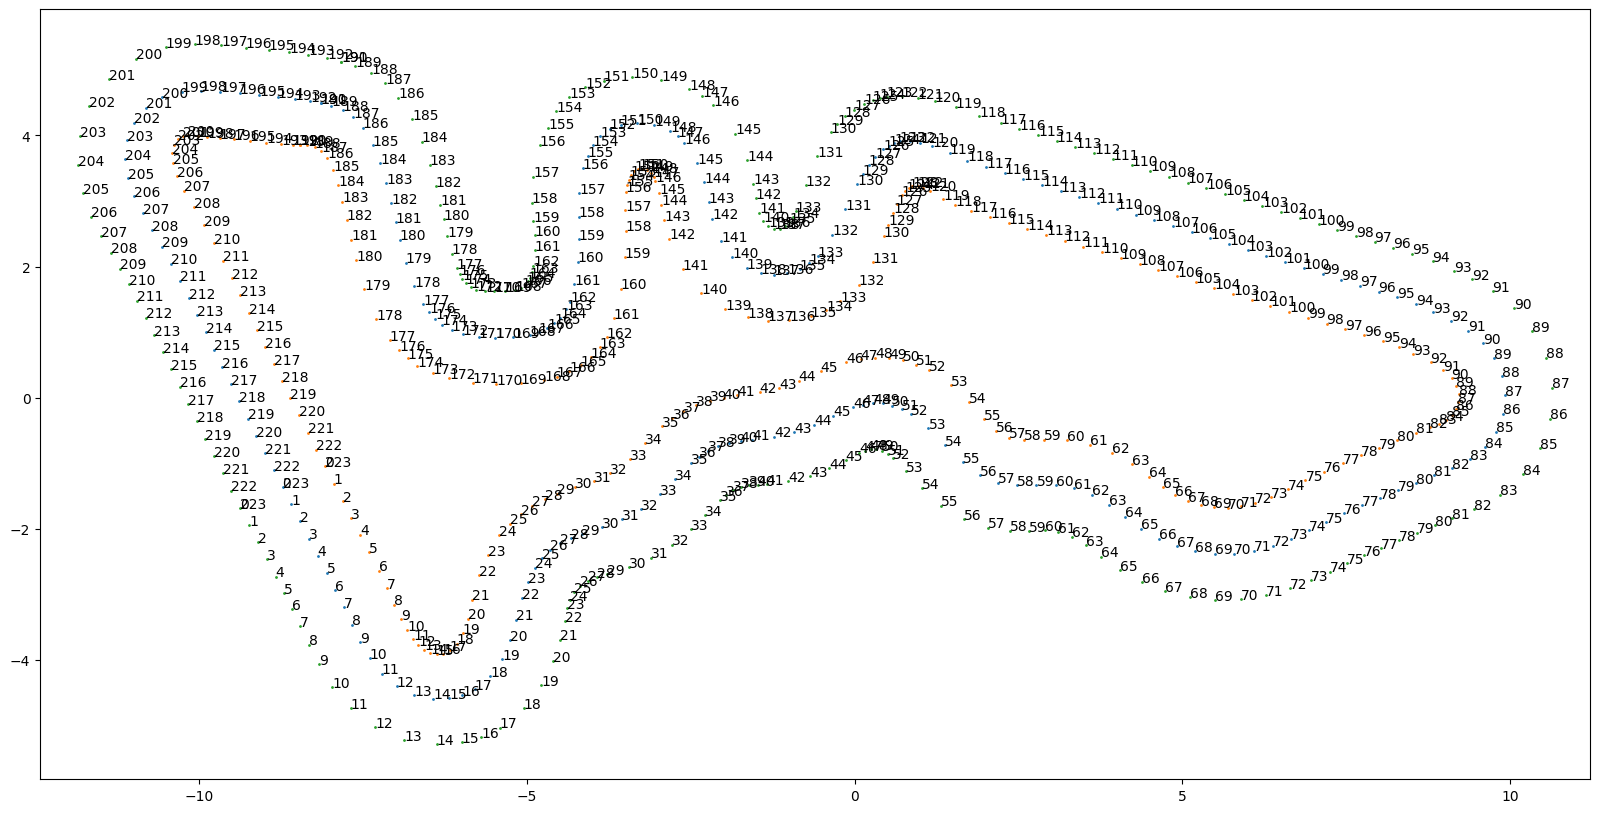

In [80]:
'''
This cell allows you to visualize the waypoints of the track.
Double check that the track matches the one you trained on.  If not, update the 'track_name' in the cell above.
'''
fig, ax = plt.subplots(figsize=(20,10))
utils.plot_points(ax, center_line)
utils.plot_points(ax, inner_border)
utils.plot_points(ax, outer_border)
ax.axis('equal')
plt.show()

## Load and format the training log
The training log has information about where the car was at each step in each episode, what action it took, what reward it received, and a few other important variables that may help you better understand what your model is doing.  This data is stored in several simtrace.csv files located at the SIM_TRACE_PATH defined above.  

Here is a look at a single row within one of my simtrace .csv's. Your simtrace files will contain identical information across multiple training episodes.
It's best to combine all simtrace files into a single .csv for convience. We will be able to process the data easier this way.

| episode | steps | X | Y | yaw | steer | throttle | action | reward | done | all_wheels_on_track | progress | closest_waypoint | track_len | tstamp | episode_status | pause_duration | 
| ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| 0 | 1.0 | 0.09777632527671878 | 1.0446896250056346 | 131.73443781111303 | 19.52068213445316 | 1.0 | [19.52068213445316 1.0] | 0.0 | False | True | 0.42128670011991776 | 1 | 33.2752652951703 | 6.58 | prepare | 0.0 |   

In [81]:
'''
This cell merges your sim_trace files into one CSV.
# You may need to adjust `episode_per_iter[action]` according to your own hyperparameters.
'''
episode_per_iter = 20

sim_trace_csvs = glob.glob(str(SIM_TRACE_PATH/'*.csv')) 
utils.merge_csv_files(MERGED_SIMTRACE_PATH, sim_trace_csvs)

df = pd.read_csv(MERGED_SIMTRACE_PATH)
iteration_arr = np.arange(math.ceil(df.episode.max() / episode_per_iter)+ 1) * episode_per_iter
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={'X': 'x', 'Y': 'y', 'tstamp': 'timestamp'})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,obstacle_crash_counter,iteration
0,0,1.0,-8.657261,-1.488881,-62.524387,-30.0,4.0,[-30.0 4.0],0.0,False,True,0.236197,0,59.350856,7.682,prepare,0.0,0,1
1,0,2.0,-8.657348,-1.488718,-62.525153,-30.0,1.2,[-30.0 1.2],1.0,False,True,0.235885,0,59.350856,7.781,in_progress,0.0,0,1
2,0,3.0,-8.654671,-1.513412,-64.659635,-30.0,1.2,[-30.0 1.2],1.0,False,True,0.274880,1,59.350856,7.833,in_progress,0.0,0,1
3,0,4.0,-8.656593,-1.536964,-67.597485,-30.0,1.2,[-30.0 1.2],1.0,False,True,0.308594,1,59.350856,7.915,in_progress,0.0,0,1
4,0,5.0,-8.665446,-1.598494,-74.836280,30.0,1.2,[30.0 1.2],1.0,False,True,0.393690,1,59.350856,7.962,in_progress,0.0,0,1


In [82]:
'''
If you chose to use a continous action space, this cell will convert it to a discrete action space for easier analysis.
'''
# Map the choices the model made in the simtrace logs into discrete buckets to allow for later visualization.
model_metadata, df = utils.continuous_to_discrete(model_metadata, df, num_angle_buckets=5, num_speed_buckets=4)
df

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,obstacle_crash_counter,iteration
0,0,1.0,-8.657261,-1.488881,-62.524387,-30.0,4.0,3,0.0,False,True,0.236197,0,59.350856,7.682,prepare,0.0,0,1
1,0,2.0,-8.657348,-1.488718,-62.525153,-30.0,1.2,0,1.0,False,True,0.235885,0,59.350856,7.781,in_progress,0.0,0,1
2,0,3.0,-8.654671,-1.513412,-64.659635,-30.0,1.2,0,1.0,False,True,0.274880,1,59.350856,7.833,in_progress,0.0,0,1
3,0,4.0,-8.656593,-1.536964,-67.597485,-30.0,1.2,0,1.0,False,True,0.308594,1,59.350856,7.915,in_progress,0.0,0,1
4,0,5.0,-8.665446,-1.598494,-74.836280,30.0,1.2,16,1.0,False,True,0.393690,1,59.350856,7.962,in_progress,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58228,139,579.0,-10.180322,1.650236,-56.301988,30.0,1.2,16,1.0,False,True,99.357516,212,59.350856,6243.497,in_progress,0.0,0,7
58229,139,580.0,-10.124776,1.556907,-57.396166,-30.0,4.0,3,1.0,False,True,99.539990,212,59.350856,6243.573,in_progress,0.0,0,7
58230,139,581.0,-10.060211,1.461156,-57.583103,-30.0,1.2,0,1.0,False,True,99.732393,212,59.350856,6243.662,in_progress,0.0,0,7
58231,139,582.0,-10.010185,1.345040,-61.717228,-30.0,4.0,3,1.0,False,True,99.945161,213,59.350856,6243.739,in_progress,0.0,0,7


In [83]:
'''
This cell normalizes the rewards to a 0-1 scale which makes them easier to interpret and plot
'''
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())

## Plot rewards per iteration

Plotting the total rewards, mean rewards, and standard deviation of rewards within each episode as a scatter plot helps you pick out useful trends to understand your model's learning process.  Ideally, as the model learns, the rewards will increase and the standard deviation will get smaller until it eventually plateaus.  However, there may be variations throughout the learning process depending on how you've written your reward function.

In [84]:
'''
This cell calculates the mean, total, and standard deviation of the rewards per iteration
'''

reward_threshold = 1

# reward graph per episode
min_episodes = min(df['episode'])
max_episodes = max(df['episode'])
print(f'Number of episodes = {max_episodes}')

total_reward_per_episode = list()
    
for epi in np.arange(min_episodes, max_episodes + 1, 1):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == episode_per_iter:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


Number of episodes = 139


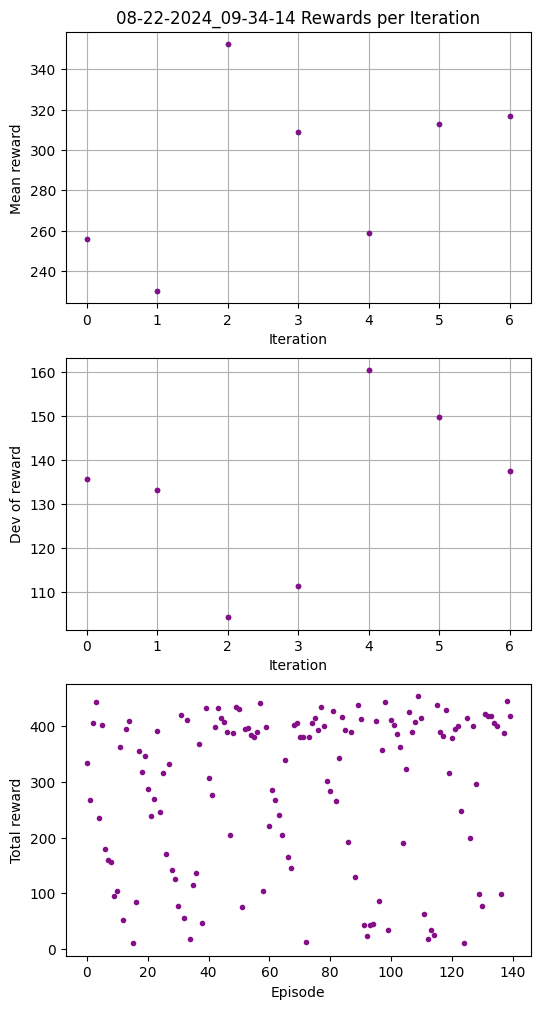

In [85]:
'''
This cell plots the mean, total, and standard deviation of the rewards per iteration
'''

fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title(f'{EXPERIMENT_FOLDER_NAME} Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= reward_threshold:
        ax.plot(rr, average_reward_per_iteration[rr], '.', color=LEIDOS_PURPLE)

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.', color=LEIDOS_PURPLE)

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= reward_threshold:
        ax.plot(rr, deviation_reward_per_iteration[rr], '.', color=LEIDOS_PURPLE)


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.', color=LEIDOS_PURPLE)
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

figure_name = FIGURES_PATH / 'rewards_per_iter.png'
plt.savefig(figure_name)

## Analyze training/evaluation metrics with progress and reward function

This graph gives you an idea whether your model has convergered or more training is required.

If you see the curve trending upwards then more training time might help the agent to get better rewards.  If it has plataued, then more training time would likely not be very helpful.  If there's no upward trend and you've trained for at least half an hour, then there might be something wrong with your reward function or your general approach.

In [86]:
'''
This cell loads the training metrics dataframe.
'''
# TRAIN_METRICS_PATH = 'C:\AWS\deepracer-contestant\logs\08-22-2024_09-34-14\5d75dd5d-145c-4f88-a3cf-2854bcc2811b'
with open(TRAIN_METRICS_PATH, 'r') as json_file:
    data = json.loads(json_file.read())
    metric_data = data['metrics']
    df_metrics = pd.DataFrame(metric_data)

training_metrics = df_metrics[df_metrics['phase'] == 'training'].copy()

# If you successfully display a metrics table, you loaded it properly!
training_metrics

,reward_score,metric_time,start_time,elapsed_time_in_milliseconds,episode,trial,phase,completion_percentage,episode_status
0,334,39359,7654,31705,1,1,training,70,Reversed
1,268,64778,39432,25346,2,2,training,59,Off track
2,405,106193,64913,41280,3,3,training,100,Lap complete
3,443,147655,106324,41331,4,4,training,100,Lap complete
4,235,171248,147787,23461,5,5,training,56,Off track
...,...,...,...,...,...,...,...,...,...
200,401,6109069,6067122,41947,136,6,training,100,Lap complete
201,99,6119056,6109200,9856,137,7,training,21,Off track
202,388,6157417,6119243,38174,138,8,training,89,Off track
203,445,6201123,6157541,43582,139,9,training,100,Lap complete


In [87]:
'''This cell calculates the episode progress, the completion percentage, and the mean reward per iteration'''

# Prepare the data for plotting
training_metrics.sort_values(by='metric_time', inplace=True)
print(f'Mean completion percentage: {training_metrics.completion_percentage.mean()}')

# Calculate the percent complete and episode progress
completion_percentage_np = np.array(training_metrics.completion_percentage)
episode_progress_buckets = np.split(
    completion_percentage_np[:episode_per_iter * (
        len(completion_percentage_np) // episode_per_iter)], len(completion_percentage_np) // episode_per_iter)
episode_progress_mean = np.mean(episode_progress_buckets, axis=1)

# calculate the episode reward mean
reward_score_np = np.array(training_metrics.reward_score)
episode_reward_buckets = np.split(
    reward_score_np[:episode_per_iter * (
        len(reward_score_np)//episode_per_iter)], len(reward_score_np) // episode_per_iter)
episode_reward_mean = np.mean(episode_reward_buckets, axis=1)


Mean completion percentage: 70.86428571428571


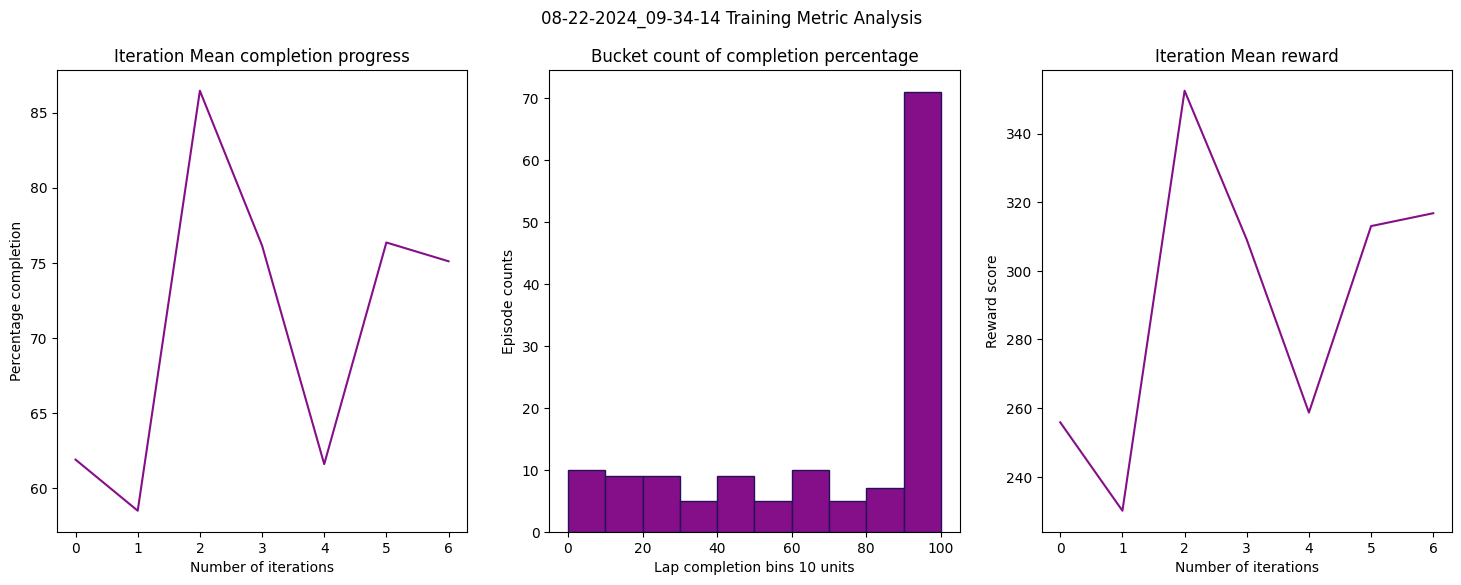

<Figure size 640x480 with 0 Axes>

In [88]:
'''
This cell plots the episode progress mean, completion percentage, and iteration reward mean
'''

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

fig.suptitle(f'{EXPERIMENT_FOLDER_NAME} Training Metric Analysis')
# Line graph showing the mean iteration of completion progress
ax1.plot(episode_progress_mean, color=LEIDOS_PURPLE)
ax1.title.set_text('Iteration Mean completion progress')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Percentage completion')

# Bar chart to show completion_percentage with bucketing of 10% bar chart
bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ax2.hist(training_metrics.completion_percentage, bins=bins, color=LEIDOS_PURPLE, edgecolor=LEIDOS_DARK)
ax2.title.set_text('Bucket count of completion percentage')
ax2.set_xlabel('Lap completion bins 10 units')
ax2.set_ylabel('Episode counts')

# Line graph showing the mean iteration of reward mean
ax3.plot(episode_reward_mean, color=LEIDOS_PURPLE)
ax3.title.set_text('Iteration Mean reward')
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Reward score')
plt.show()

figure_name = FIGURES_PATH / 'training_metric_analysis.png'
plt.savefig(figure_name)

## Analyze the reward distribution for your reward function

It's helpful to visualize what behaviors your reward function is actually rewarding.  The following plot creates a heatmap of how much reward the model receives at each location on the map on average.

If you rewarded your model highly for staying in the center, the center line of the track should be the brightest.  If you reward your model for going fast, the places where it went the fastest will be the brightest.

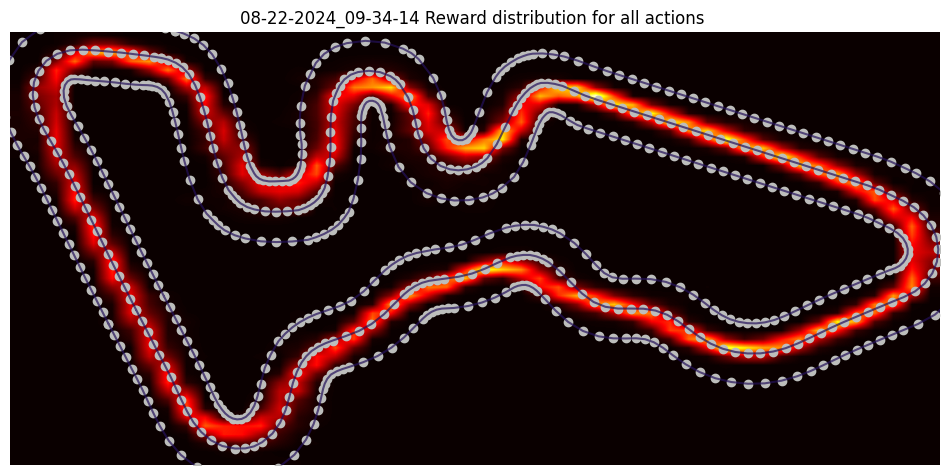

In [89]:
'''
This cell plots the reward distribution across all events and actions as a heatmap.
'''
track,extent = utils.plot_track(df, center_line, inner_border, outer_border, track_size=(12, 12))
title = f'{EXPERIMENT_FOLDER_NAME} Reward distribution for all actions '
plt.title(title)
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin='lower') 
figure_name = FIGURES_PATH / f'{title}.png'
plt.savefig(figure_name)

### Plot a particular iteration

The above plot combined all iterations, but we can look at performance for a single iteration, which we do in the next cell.


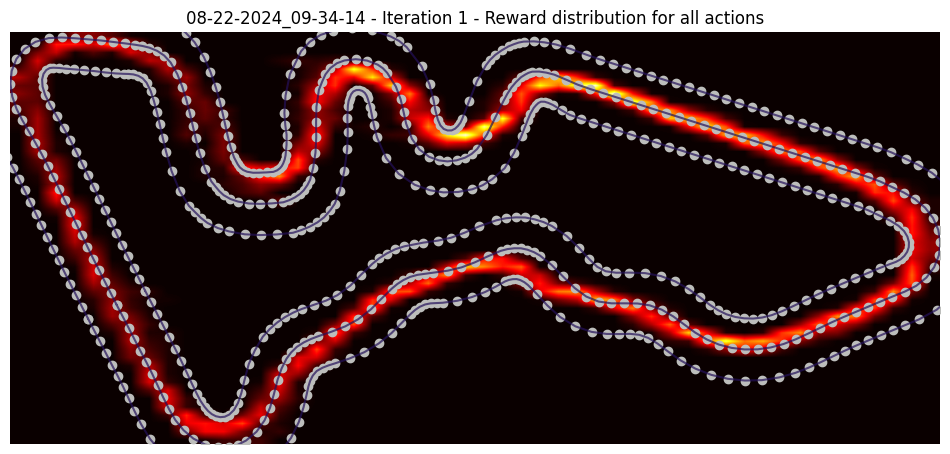

In [90]:
'''
This cell plots the reward distribution across for all actions as a heatmap.
Set the iteration_id below to the iteration you'd like to view
'''
iteration_id = 1

track,extent = utils.plot_track(df[df['iteration'] == iteration_id], center_line, inner_border, outer_border, track_size=(12, 12))
title = f'{EXPERIMENT_FOLDER_NAME} - Iteration {iteration_id} - Reward distribution for all actions'
plt.title(title)
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin='lower')
figure_name = FIGURES_PATH / f'{title}.png'
plt.savefig(figure_name)

### Path taken for top reward iterations

We can also plot the actual behavior of the car when it received the highest reward.  This can help confirm whether or not we're rewarding the right behavior.

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

The top 3 highest reward episodes are [109, 138, 3]
Episode 109 {'mean-distance-to-center': 0.15411083817831675, 'std-distance-to-center': 0.13075946826991966, 'median-distance-to-center': 0.11402419217206125}
Episode 138 {'mean-distance-to-center': 0.15000770471921168, 'std-distance-to-center': 0.1161627228562735, 'median-distance-to-center': 0.12690429457131244}
Episode 3 {'mean-distance-to-center': 0.1806490823452716, 'std-distance-to-center': 0.15241585458661197, 'median-distance-to-center': 0.1293577920798026}


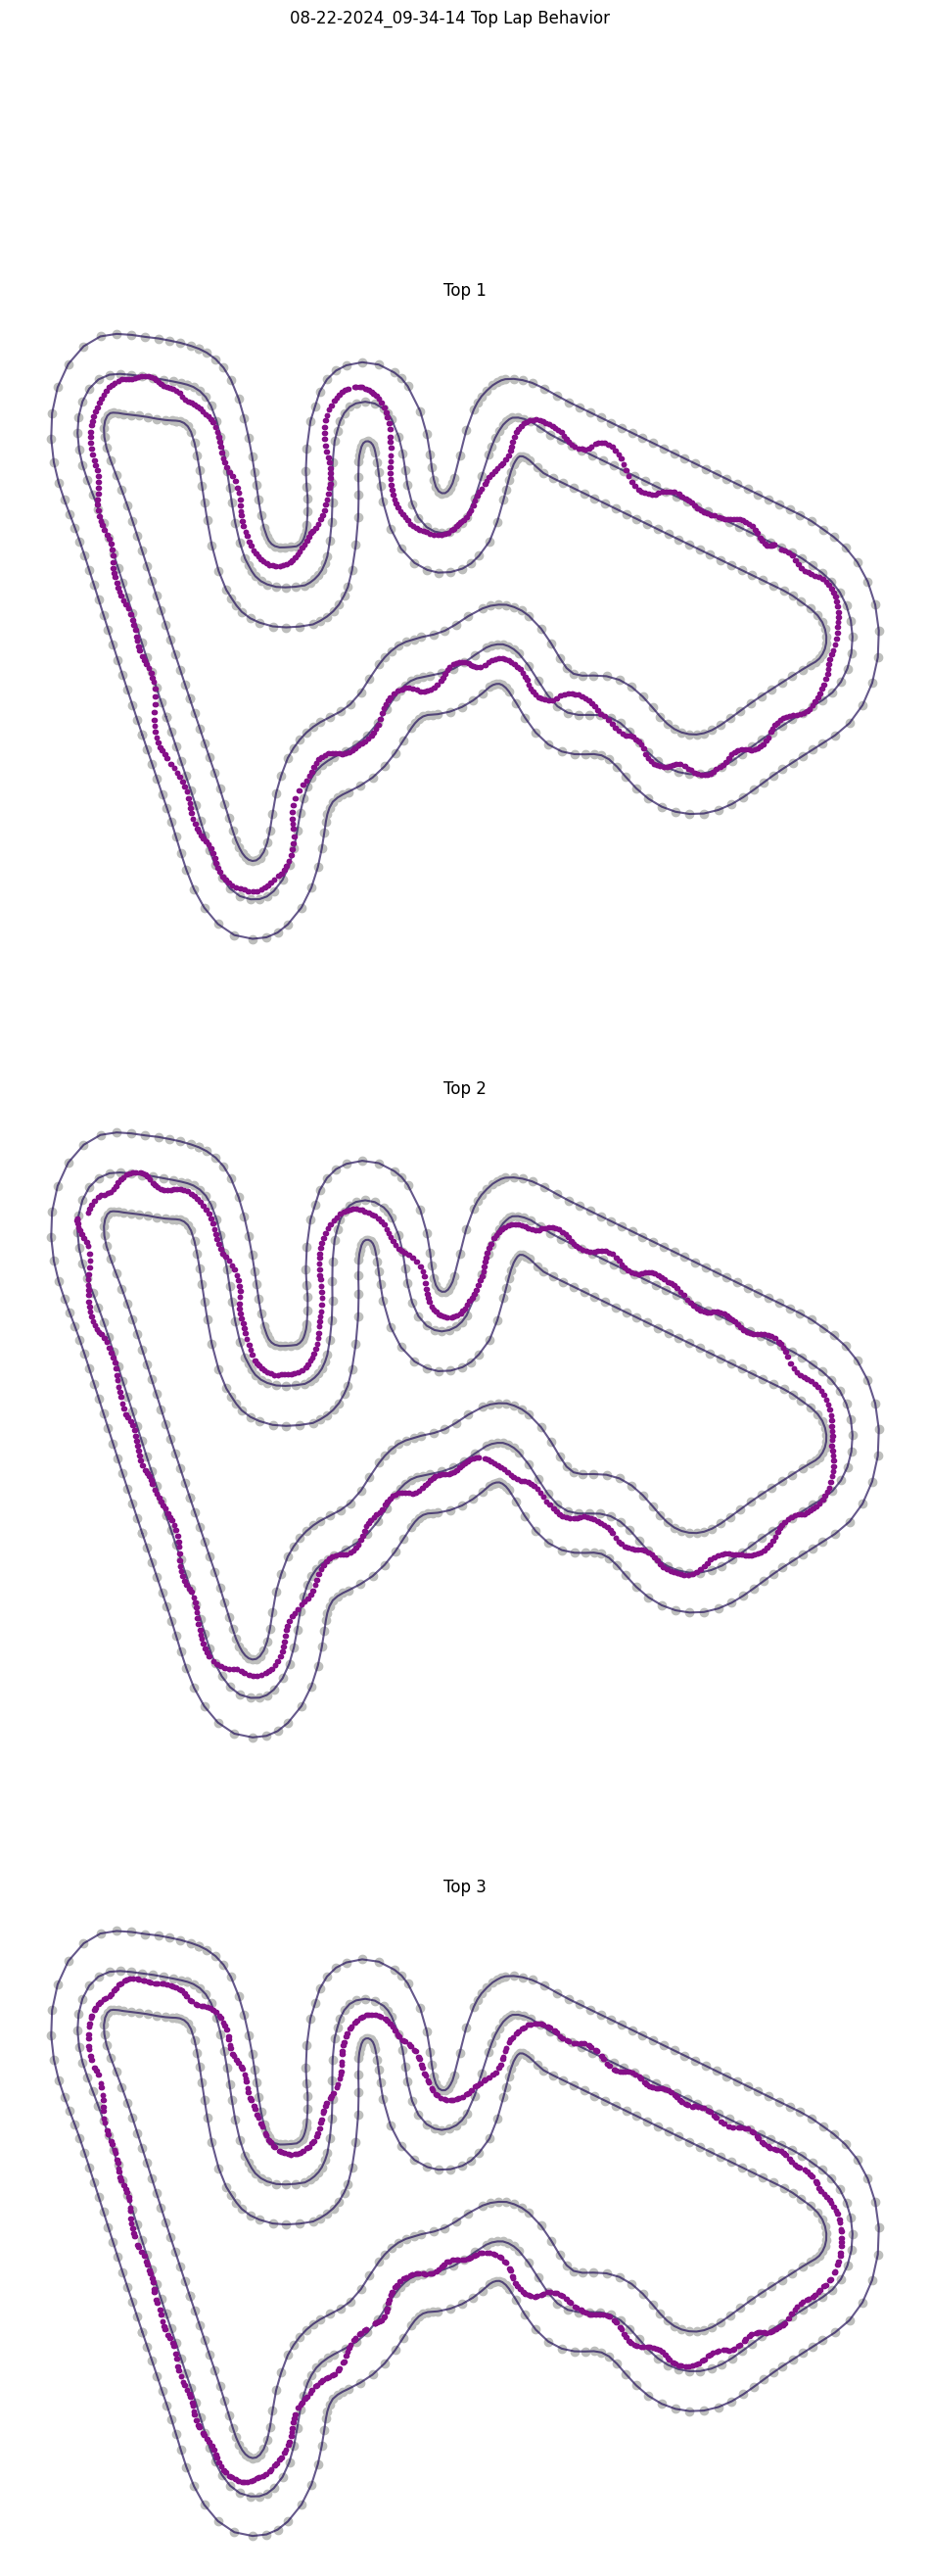

In [91]:
'''
This cell plots the model behavior for the three episodes with the highest reward.
'''
action_dict, episode_dict, sorted_episodes = utils.episode_parser(df)
fig = utils.plot_top_laps(sorted_episodes[:], center_line, inner_border, outer_border, episode_dict, n_laps=3)
title = f'{EXPERIMENT_FOLDER_NAME} Top Lap Behavior'
fig.suptitle(title)
print(f'The top 3 highest reward episodes are {sorted_episodes[:3]}')
for e in sorted_episodes[:3]:
    print(f'Episode {e} {utils.get_distance_to_center_stats(episode_dict[e], center_line)}')
figure_name = FIGURES_PATH / f'{title}.png'
plt.savefig(figure_name)

### Path taken in a particular episode

Set the episode_id below to the episode you'd like to view

Episode 1 {'mean-distance-to-center': 0.18009664954744886, 'std-distance-to-center': 0.16844442407089497, 'median-distance-to-center': 0.12225227581474385}


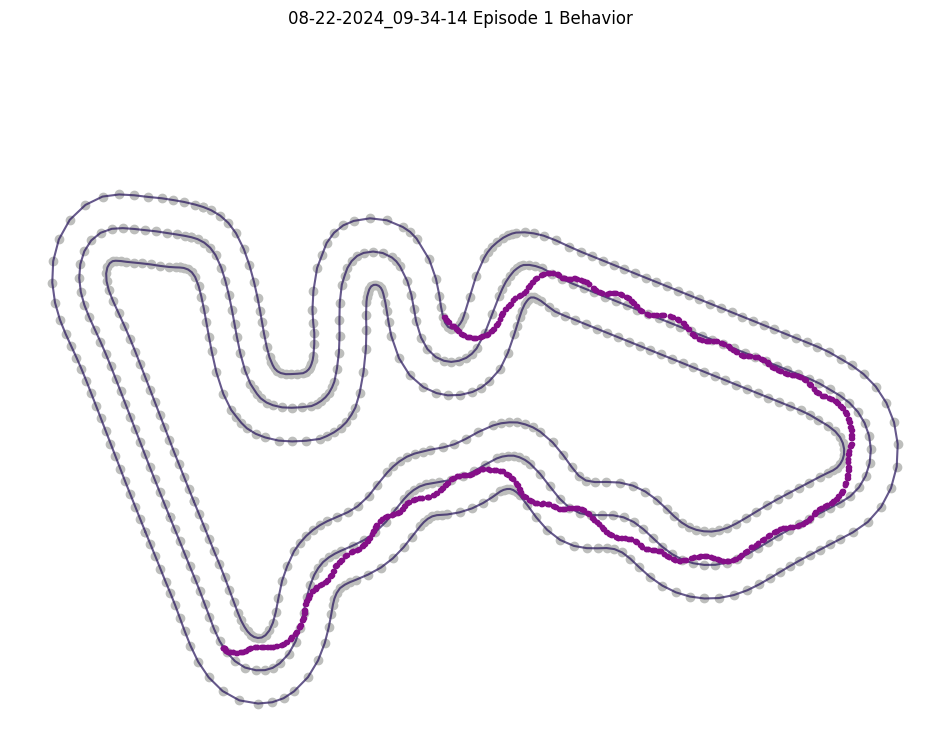

In [92]:
'''
This cell plots the model behavior for an individual episode.
Set the episode_id below to the episode you'd like to view
'''

episode_id = 1
print(f'Episode {episode_id} {utils.get_distance_to_center_stats(episode_dict[episode_id], center_line)}')
fig = utils.plot_episode_run(df, center_line, inner_border, outer_border, episode=episode_id)
title = f'{EXPERIMENT_FOLDER_NAME} Episode {episode_id} Behavior'
fig.suptitle(title)
figure_name = FIGURES_PATH / f'{title}.png'
plt.savefig(figure_name)

### Path taken in a particular Iteration


Iteration 1 episode 0 {'mean-distance-to-center': 0.16726034052444752, 'std-distance-to-center': 0.13488233103574943, 'median-distance-to-center': 0.1282854770522272}
Iteration 1 episode 1 {'mean-distance-to-center': 0.18009664954744886, 'std-distance-to-center': 0.16844442407089497, 'median-distance-to-center': 0.12225227581474385}
Iteration 1 episode 2 {'mean-distance-to-center': 0.20856167982578497, 'std-distance-to-center': 0.18336665875136085, 'median-distance-to-center': 0.14490566144235362}
Iteration 1 episode 3 {'mean-distance-to-center': 0.1806490823452716, 'std-distance-to-center': 0.15241585458661197, 'median-distance-to-center': 0.1293577920798026}
Iteration 1 episode 4 {'mean-distance-to-center': 0.2065510041594982, 'std-distance-to-center': 0.19680512399249225, 'median-distance-to-center': 0.1424163354877774}
Iteration 1 episode 5 {'mean-distance-to-center': 0.20320203511852616, 'std-distance-to-center': 0.16502225915441213, 'median-distance-to-center': 0.1623990895804543

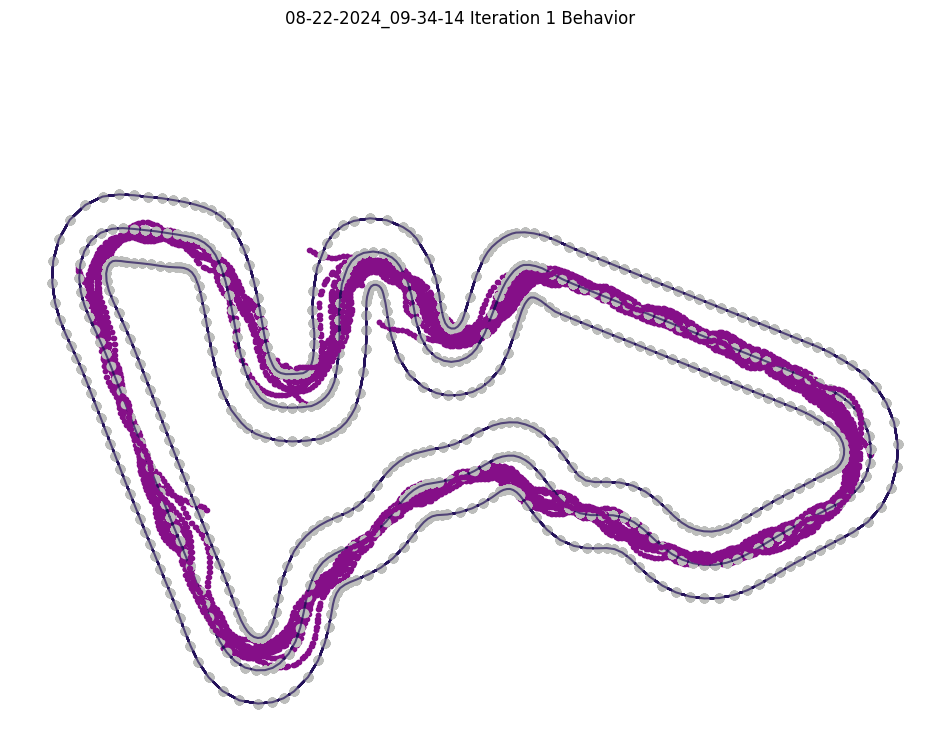

In [93]:
'''
This cell plots the model behavior for each episode in an iteration on top of each other.
Set the iteration_id below to the iteration you'd like to view
'''

iteration_id = 1

for index in range((iteration_id - 1) * episode_per_iter, (iteration_id) * episode_per_iter):
    print(f'Iteration {iteration_id} episode {index} {utils.get_distance_to_center_stats(episode_dict[index], center_line)}')
    fig = utils.plot_episode_run(df, center_line, inner_border, outer_border, episode=index)

title = f'{EXPERIMENT_FOLDER_NAME} Iteration {iteration_id} Behavior'
fig.suptitle(title)
figure_name = FIGURES_PATH / f'{title}.png'
plt.savefig(figure_name)

## Simulation Image Analysis - Probability distribution on decisions (actions)

It may be helpful to look at the distributions of which actions your model chooses to take.

Is the model making decisions that are "too close" or is it confident for the laps it finishes?  If the top and second best decisions are far apart, the model must likely be making more confident decisions.

Models which appears to have a better seperation in probabability will work better in sim2real experiments.

#### Download all the checkpoints (provided as an example).  

In [104]:
'''
This cell creates an array called model_inference that stores model decisions.
'''
image_path = Path('simulation_images') / '*.png'
all_files = sorted(glob.glob(str(image_path)))

# feel free to manually add more model paths to this list
# MODELS_FILE_PATH = MODEL_PATH / 'agent' / 'model.pb'
model_file = str(MODELS_FILE_PATH)
model_inference = []

model, obs, model_out = utils.load_session(model_file, sensor)
for f in all_files[:]:
    print(f)
    img = Image.open(f)
    img_arr = np.array(img)
    img_arr = utils.rgb_to_gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    current_state = {'observation': img_arr}
    y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
    model_inference.append(y_output)
    
model.close()
tf.reset_default_graph()

Device mapping: no known devices.
load graph: C:\AWS\deepracer-contestant\logs\08-22-2024_09-34-14\john-braunsdorf\agent\model.pb


KeyError: "The name 'main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA:0' refers to a Tensor which does not exist. The operation, 'main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA', does not exist in the graph."

##### Plot the distribution of model output, which corresponds to which actions it took.

Inference for model: C:\AWS\deepracer-contestant\logs\08-22-2024_09-34-14\john-braunsdorf\agent\model.pb


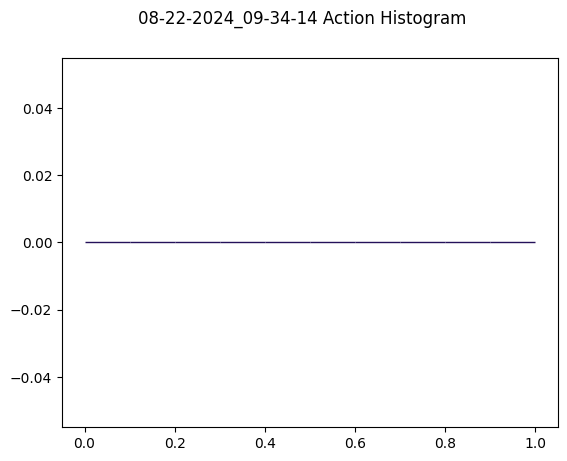

<Figure size 640x480 with 0 Axes>

In [97]:
'''
This cell plots a histogram of how frequently the model selected each possible action
'''
prob_diff = []
print(f'Inference for model: {model_file}')
for mi in model_inference:
    max1, max2 = mi.argsort()[-2:][::-1]
    prob_diff.append(mi[max1] - mi[max2])
plt.hist(prob_diff, color=LEIDOS_PURPLE, edgecolor=LEIDOS_DARK)
plt.suptitle(f'{EXPERIMENT_FOLDER_NAME} Action Histogram')
plt.show()
filepath = FIGURES_PATH / 'action_distribution.png'
plt.savefig(filepath)

# Model CSV Analysis

Download the model from the console `AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model`
and make sure the MODEL_CSV_PATH is defined appropriately.


This csv contains lots of information that you can look into if you want to dive deeper.  We've demonstrated how to plot the episode length and listed some of the other features you may plot if you think they'll be useful.  You are allowed to use LLMs such as ChatGPT to help generate plots or to look up what some of these values might mean.  You may also ask about them on the forum or at office hours.

#### Model CSV Columns
 Episode #', 'Training Iter', 'Epoch', 'In Heatup', 'ER #Transitions', 'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon', 'Shaped Training Reward', 'Training Reward', 'Update Target Network', 'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward', 'Success Rate', 'Inverse Propensity Score', 'Direct Method Reward', 'Doubly Robust', 'Weighted Importance Sampling', 'Sequential Doubly Robust', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max', 'Loss/Min', 'Learning Rate/Mean', 'Learning Rate/Stdev', 'Learning Rate/Max', 'Learning Rate/Min', 'Grads (unclipped)/Mean', 'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max', 'Grads (unclipped)/Min', 'Discounted Return/Mean', 'Discounted Return/Stdev', 'Discounted Return/Max', 'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max', 'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max', 'Advantages/Min', 'Values/Mean', 'Values/Stdev', 'Values/Max', 'Values/Min', 'Value Loss/Mean', 'Value Loss/Stdev', 'Value Loss/Max', 'Value Loss/Min', 'Policy Loss/Mean', 'Policy Loss/Stdev', 'Policy Loss/Max', 'Policy Loss/Min', 'Value Targets/Mean', 'Value Targets/Stdev', 'Value Targets/Max', 'Value Targets/Min', 'KL Divergence/Mean', 'KL Divergence/Stdev', 'KL Divergence/Max', 'KL Divergence/Min', 'Likelihood Ratio/Mean', 'Likelihood Ratio/Stdev', 'Likelihood Ratio/Max', 'Likelihood Ratio/Min', 'Clipped Likelihood Ratio/Mean', 'Clipped Likelihood Ratio/Stdev', 'Clipped Likelihood Ratio/Max', 'Clipped Likelihood Ratio/Min'

In [69]:
model_csv = pd.read_csv(MODEL_CSV_PATH)
model_csv.head()

,Episode #,Training Iter,Epoch,In Heatup,ER #Transitions,ER #Episodes,Episode Length,Total steps,Epsilon,Shaped Training Reward,...,KL Divergence/Max,KL Divergence/Min,Likelihood Ratio/Mean,Likelihood Ratio/Stdev,Likelihood Ratio/Max,Likelihood Ratio/Min,Clipped Likelihood Ratio/Mean,Clipped Likelihood Ratio/Stdev,Clipped Likelihood Ratio/Max,Clipped Likelihood Ratio/Min
0,1,0.0,0.0,0.0,476.0,1.0,476.0,476.0,0.1,334.400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.0,0.0,0.0,856.0,2.0,380.0,856.0,0.1,267.905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.0,0.0,0.0,1475.0,3.0,619.0,1475.0,0.1,405.104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.0,0.0,0.0,2095.0,4.0,620.0,2095.0,0.1,443.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.0,0.0,0.0,2447.0,5.0,352.0,2447.0,0.1,235.312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


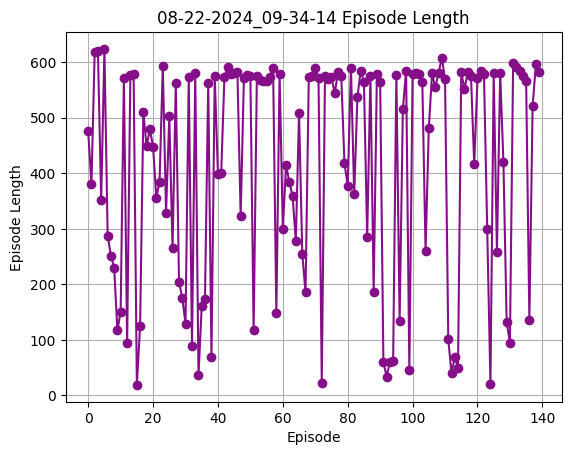

<Figure size 640x480 with 0 Axes>

In [72]:
'''
Here we plot episode length for each episode as an example.
You can replace the column_to_plot with any of the column names in model_csv, though if there are NaN values, your plot might be blank or throw an error.ß
'''
column_to_plot = 'Episode Length'
title_name = column_to_plot.replace('/', '-')
title = f'{EXPERIMENT_FOLDER_NAME} {title_name}'

# Create the plot using matplotlib
plt.figure()
plt.plot(model_csv[column_to_plot], marker='o', linestyle='-', color=LEIDOS_PURPLE)
plt.title(title)
plt.xlabel('Episode')
plt.ylabel(column_to_plot)
plt.grid(True)  # Optional: add a grid
plt.show()
fig_path = FIGURES_PATH / f'{title_name}.png'
plt.savefig(fig_path)

## What is the model looking at?

Going beyond observing model behavior, we can create a visual heatmap of where the model is "looking" to make its decisions.

Using the method Gradcam from (https://arxiv.org/pdf/1610.02391.pdf), we can use the model gradients to identify what parts of the input the model uses most when making decisions.  This provides a degree of explainability which is helpful both for trying to improve your model and also for creating safe, trusted AI.  The following code implements Gradcam for you, but we encourage checking it out as it's a really cool tool for machine learning.

In [73]:
'''
This cell creates the gradcam heatmaps.
'''

model, obs, model_out = utils.load_session(str(MODELS_FILE_PATH), sensor)
heatmaps = []

#Just need to match up the shape of the neural network
if 'action_space_type' in model_metadata and model_metadata['action_space_type']=='continuous':
    num_of_actions = 2
else:
    # Track Segment Labels
    action_names = []
    for action in model_metadata['action_space']:
        action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])
    num_of_actions = len(action_names)

for f in all_files[:5]:
    print(f)
    img = np.array(Image.open(f))
    heatmap = utils.visualize_gradcam_discrete_ppo(sess=model, rgb_img=img, sensor=sensor, category_index=0, num_of_actions=num_of_actions)
    heatmaps.append(heatmap)
tf.reset_default_graph()

Device mapping: no known devices.
load graph: C:\AWS\deepracer-contestant\logs\08-22-2024_09-34-14\john-braunsdorf\agent\model.pb


KeyError: "The name 'main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA:0' refers to a Tensor which does not exist. The operation, 'main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA', does not exist in the graph."

In [88]:
'''
This cell plots the gradcam heatmaps
'''
for i, hm in enumerate(heatmaps):
    plt.imshow(hm)
    plt.suptitle(f'{EXPERIMENT_FOLDER_NAME} Gradcam Heatmap {i}')
    plt.show()

NameError: name 'heatmaps' is not defined

In [89]:
'''
This cell saves the heatmaps generated above
'''
for i, hm in enumerate(heatmaps):
    plt.imshow(hm)
    plt.suptitle(f'{EXPERIMENT_FOLDER_NAME} Gradcam Heatmap {i}')
    filepath = GRADCAM_PATH / f'heatmap_{i}.png'
    plt.savefig(filepath)
    plt.close()

NameError: name 'heatmaps' is not defined